# Introduction

In this week, our goal is to solve the minimization problem for each various functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from copy import deepcopy
from genetic_utils import *
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline  

# Contents
* Helper Functions(Just for beta version)
* Functions
* Fitness Function
* Gray to Floating-point Conversion
* Genetic Algorithm (Binary Representation)
* Visualization (Binary Representation)
* Chromosome Design
* Population Initialization
* Random Mutation
* Uniform Mutation for floating point genes
* Linear Recombination Crossover
* Genetic Algorithm (Floating-point Representation)
* Visualization (Floating-point Representation)

# Helper Functions(Just for beta version)

In [2]:
def data_point_creator(x_bound, y_bound, func, prec=.1):
    x = np.arange(-5.12, 5.12, prec)
    y = np.arange(-5.12, 5.12, prec)
    x, y = np.meshgrid(x, y)
    z = np.array(list(map(func, x, y)))
    return x, y, z

In [3]:
def three_d_plot(x, y, z, p_type='surface', genetic_points=None, with_countour=False):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    plot_dict = {
        'surface': ax.plot_surface,
        'wireframe': ax.plot_wireframe,
    }
    
    assert p_type in plot_dict.keys()
    
    def animate(i):
        x_gen = genetic_points[i, :, 0]
        y_gen = genetic_points[i, :, 1]
        ax.clear()
        ax.scatter(x_gen, y_gen, c='lightcoral',s=1)
        plot_dict[p_type](x, y, z)
        ax.contour(x, y, z, zdir='z', offset=-2, cmap=cm.coolwarm)
        ax.set_title('Generation {}'.format(i))
        ax.set_xlabel('X')
        ax.set_xlim(-10, 10)
        ax.set_ylabel('Y')
        ax.set_ylim(-10, 10)
        ax.set_zlabel('Z')
        ax.set_zlim(-2.2, 25)
        return ax
    
    plot_dict[p_type](x, y, z)
    
    if with_countour :
#         cset = ax.contour(x, y, z, zdir='z', offset=-25, cmap=cm.coolwarm)
#         cset = ax.contour(x, y, z, zdir='x', offset=-10, cmap=cm.coolwarm)
        cset = ax.contour(x, y, z, zdir='y', offset=10, cmap=cm.coolwarm)
        ax.set_xlabel('X')
        ax.set_xlim(-10, 10)
        ax.set_ylabel('Y')
        ax.set_ylim(-10, 10)
        ax.set_zlabel('Z')
        ax.set_zlim(-25, 25)
    if not(genetic_points is None) :
        anim = animation.FuncAnimation(fig, animate, frames=genetic_points.shape[0], interval=200)
        plt.close()
        # call our new function to display the animation
        return HTML(anim.to_jshtml())

# Functions

## De Jong’s function

In [4]:
de_jong_func = lambda x, y: x**2 + y**2

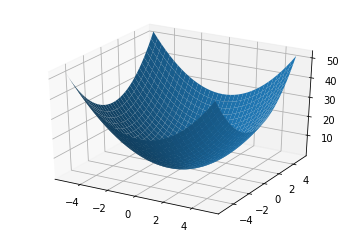

In [5]:
three_d_plot(*data_point_creator(-5.12, 5.12, de_jong_func))

## Axis parallel hyper-ellipsoid function

In [6]:
a_p_hyper_ellipsoid_func = lambda x, y: x**2 + 2*y**2

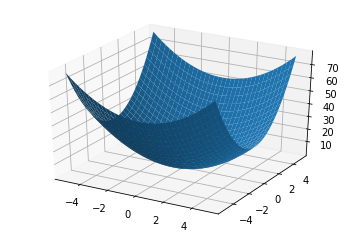

In [7]:
three_d_plot(*data_point_creator(-5.12, 5.12, a_p_hyper_ellipsoid_func))

## Rosenbrock’s valley

In [8]:
ros_valley_func = lambda x, y: 100*(y - x**2)**2 + (1 -x)**2

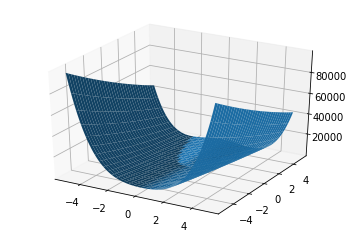

In [9]:
three_d_plot(*data_point_creator(-2.048, 2.048, ros_valley_func))

## Rastrigin’s function

In [10]:
rastrigin_func = lambda x, y: 20 + np.floor(x**2 + 10*np.cos(2*np.pi*x)) + np.floor(y**2 + 10*np.cos(2*np.pi*y))

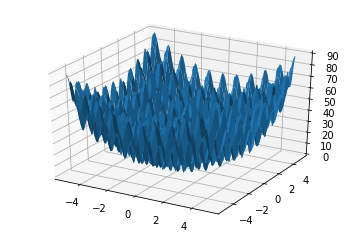

In [11]:
three_d_plot(*data_point_creator(-5.12, 5.12, rastrigin_func))

You can find other functions that you can use <a href="https://www.robertmarks.org/Classes/ENGR5358/Papers/functions.pdf">here</a>.

# Gray to Floating-point Conversion

First we implement Gray to Binary function as follow(For mor information check <a href="https://testbook.com/blog/conversion-from-gray-code-to-binary-code-and-vice-versa/">here</a>.

![gray_to_binary_conversion](figs/gray_to_bin.PNG)

In [12]:
def gray_to_bin(gray_code):
    xor = lambda a, b: bool(a) != bool(b)
    
    nd = len(gray_code)
    b_code = [True] * nd
    b_code[0] = gray_code[0]
    
    for i in range(1, nd):
        b_code[i] = xor(b_code[i-1], gray_code[i])
        
    return b_code

#TODO : ADD Formules

In [13]:
def gray_to_float(gray_code, x_min, x_max):
    b_code = gray_to_bin(gray_code)
    nd = len(b_code)
    float_val = x_min + (x_max - x_min)/(2**nd -1) * sum([b_code[i]*(2**(nd - i - 1)) for i in range(nd)])
    return float_val

# Fitness Function

In [14]:
def func_fitness(chrom, func, x_min, x_max, bit_num=None, is_gray=True, epsilon=.01):
    if is_gray :
        assert bit_num != None, 'bit_num value is missing'
        real_vals = []
        for i in range(len(chrom.genes)//bit_num):
            real_vals.append(gray_to_float(chrom.genes[i*bit_num: (i+1)*bit_num], -5.12, 5.12))
    else :
        real_vals = chrom.genes
    return 1/(func(*real_vals)+epsilon)

# Genetic Algorithm (Binary Representation)

In [15]:
def bin_genetic_algorithm(pop_size=50, iter_num=50, pm=.4,
                            pc=.3, opt_func=de_jong_func, bit_num=10,
                            x_min=-5.12, x_max=5.12, epsilon=.01,
                            seed=0) :
    
    # Creating Arrays for saving the individuals of populations
    pop_config = np.ndarray((iter_num, pop_size), dtype=object)
    best_fitness = float('-inf')

    # Initializing the population
    pop = population_init(pop_size, 2*bit_num)

    # Calculating Fitness of each individual
    for i in range(pop_size) :
        pop[i].fitness = func_fitness(pop[i], opt_func, x_min, x_max, bit_num, epsilon=epsilon)
        if best_fitness < pop[i].fitness :
            best_fitness = pop[i].fitness

    pop_config[0] = pop
    # Loop : Selection, Crossover, Mutation
    for generation in range(1, iter_num) :
        print('Best fitness in generation {} : {}'.format(generation-1, best_fitness))
        new_pop = np.array([])

        # Crossover
        for i in range(int(pop_size/2)) :
            parent1, parent2 = one_point_crossover(pop, roulette_selection, pc)
            new_pop = np.append(new_pop, [parent1, parent2])

        # Mutation
        for i in range(pop_size) :
            new_pop[i] = random_mutation(new_pop[i], pm/pop_size)

        # Fitness Calculation
        for i in range(pop_size) :
            new_pop[i].fitness = func_fitness(pop[i], opt_func, x_min, x_max, bit_num, epsilon=epsilon)
            if best_fitness < pop[i].fitness :
                best_fitness = pop[i].fitness

        pop = new_pop
        pop_config[generation] = pop

    print('Best fitness in generation {} : {}'.format(iter_num, best_fitness))
    return pop_config

In [16]:
x_min = -5.12
x_max = 5.12
pop_size = 200
iter_num = 100
pm = 0.8
pc = .6
opt_func = de_jong_func
bit_num = 10
de_jong_out = bin_genetic_algorithm(pop_size, iter_num, pm, pc, opt_func, bit_num, x_min, x_max)

Best fitness in generation 0 : 15.300329767429432
Best fitness in generation 1 : 15.300329767429432
Best fitness in generation 2 : 15.300329767429432
Best fitness in generation 3 : 57.92339667333544
Best fitness in generation 4 : 57.92339667333544
Best fitness in generation 5 : 57.92339667333544
Best fitness in generation 6 : 57.92339667333544
Best fitness in generation 7 : 93.88550559563663
Best fitness in generation 8 : 93.88550559563663
Best fitness in generation 9 : 93.88550559563663
Best fitness in generation 10 : 93.88550559563663
Best fitness in generation 11 : 93.88550559563663
Best fitness in generation 12 : 93.88550559563663
Best fitness in generation 13 : 93.88550559563663
Best fitness in generation 14 : 93.88550559563663
Best fitness in generation 15 : 93.88550559563663
Best fitness in generation 16 : 93.88550559563663
Best fitness in generation 17 : 93.88550559563663
Best fitness in generation 18 : 93.88550559563663
Best fitness in generation 19 : 93.88550559563663
Best fi

# Visualization (Binary Representation)

First we extract the useful data from output data for visualization:

In [17]:
ext_out = np.ndarray((iter_num, pop_size, 2))
for i, pop in enumerate(de_jong_out):
    for j, chrom in enumerate(pop):
        real_vals = []
        for t in range(len(chrom.genes)//bit_num):
            real_vals.append(gray_to_float(chrom.genes[t*bit_num: (t+1)*bit_num], -5.12, 5.12))
        ext_out[i, j, :] = real_vals
ext_out = np.array(ext_out)

In [ ]:
three_d_plot(*data_point_creator(-5.12, 5.12, de_jong_func), genetic_points=ext_out, p_type='wireframe')

# Chromosome Design

In [19]:
class Chromosome :
    def __init__(self, length, x_max=None, x_min=None, ctype='binary') :
        if ctype == 'binary':
            self.genes = np.random.rand(length) > .5
        else:
            assert x_min != None
            assert x_max != None
            self.genes = np.array([np.random.rand() * (x_max - x_min) + x_min for _ in range(length)])
        self.fitness = float('-inf')
    def __len__(self) :
        return len(self.genes)
    
    def reset(self) :
        self.fitness = float('-inf')

# Population Initialization

In [20]:
float_population_init = lambda size, chrom_size, x_min, x_max : \
    np.array([Chromosome(chrom_size, x_max, x_min, 'float') for _ in range(size)])

# Random Mutation

In [21]:
def random_mutation_float(chrom, pm, x_min, x_max):
    if np.random.random() < pm :
        point = np.random.randint(len(chrom))
        chrom.genes[point] = np.random.rand() * (x_max - x_min) + x_min
    return chrom

# Uniform Mutation for floating point genes

In [22]:
def uniform_mutation(chrom, pm):
    if np.random.random() < pm :
        point = np.random.randint(len(chrom))
        if np.random.rand() > .5 :
            chrom.genes[point] = chrom.genes[point] + np.random.rand() * x_max - chrom.genes[point]
        else :
            chrom.genes[point] = chrom.genes[point] + np.random.rand() * chrom.genes[point] - x_min
    return chrom

# Linear Recombination Crossover
One point & two point crossovers aren't good for solving this problem, why?

In [23]:
def linear_rec_crossover(pop, selection_method, fitness_method, pc) :

    p1 = selection_method(pop)
    p2 = selection_method(pop)
    
    chrom_length = len(p1)
    
    if np.random.random() < pc :
        c1 = Chromosome(chrom_length)
        c2 = Chromosome(chrom_length)
        c3 = Chromosome(chrom_length)
        
        c1.genes = .5*p1.genes + .5*p2.genes # I think it should multiplied by 2
        c2.genes = 1.5*p1.genes - .5*p2.genes
        c3.genes = - .5*p1.genes + 1.5*p2.genes
        
        c1.fitness = fitness_method(c1)
        c2.fitness = fitness_method(c2)
        c3.fitness = fitness_method(c3)
        
        if c1.fitness > c2.fitness > c3.fitness or c2.fitness > c1.fitness > c3.fitness:
            return c1, c2
        elif c3.fitness > c2.fitness > c1.fitness or c2.fitness > c3.fitness > c1.fitness:
            return c2, c3
        else:
            return c1, c3
            
    else :
        c1 = deepcopy(p1)
        c2 = deepcopy(p2)
        
        # Reset fitness of each parent
        c1.reset()
        c2.reset()
    
        return c1, c2

# Genetic Algorithm (Floating-point Representation)

In [24]:
def float_genetic_algorithm(pop_size=50, iter_num=50, pm=.4,
                            pc=.3, opt_func=de_jong_func,
                            x_min=-5.12, x_max=5.12, epsilon=.01,
                            seed=0) :
    
    # Creating Arrays for saving the individuals of populations
    pop_config = np.ndarray((iter_num, pop_size), dtype=object)
    best_fitness = float('-inf')

    # Initializing the population
    pop = float_population_init(pop_size, 2, x_max, x_min)

    # Calculating Fitness of each individual
    for i in range(pop_size) :
        pop[i].fitness = 1/(opt_func(*pop[i].genes) + epsilon)
        if best_fitness < pop[i].fitness :
            best_fitness = pop[i].fitness

    pop_config[0] = pop
    # Loop : Selection, Crossover, Mutation
    for generation in range(1, iter_num) :
        print('Best fitness in generation {} : {}'.format(generation-1, best_fitness))
        new_pop = np.array([])

        # Crossover
        for i in range(int(pop_size/2)) :
            parent1, parent2 = linear_rec_crossover(pop, roulette_selection, 
                                                    lambda chrom: 1/(opt_func(*chrom.genes) + epsilon), pc)
            
            new_pop = np.append(new_pop, [parent1, parent2])

        # Mutation
        for i in range(pop_size) :
            new_pop[i] = random_mutation_float(new_pop[i], pm/pop_size, x_min, x_max)

        # Fitness Calculation
        for i in range(pop_size) :
            new_pop[i].fitness = 1/(opt_func(*pop[i].genes) + epsilon)
            if best_fitness < pop[i].fitness :
                best_fitness = pop[i].fitness

        pop = new_pop
        pop_config[generation] = pop

    print('Best fitness in generation {} : {}'.format(iter_num, best_fitness))
    return pop_config

In [25]:
x_min = -5.12
x_max = 5.12
pop_size = 200
iter_num = 100
pm = 0.8
pc = .6
opt_func = de_jong_func
de_jong_out = float_genetic_algorithm(pop_size, iter_num, pm, pc, opt_func, x_min, x_max)

Best fitness in generation 0 : 8.569773885105727
Best fitness in generation 1 : 8.569773885105727
Best fitness in generation 2 : 8.569773885105727
Best fitness in generation 3 : 40.119305092919475
Best fitness in generation 4 : 73.95436532937858
Best fitness in generation 5 : 73.95436532937858
Best fitness in generation 6 : 73.95436532937858
Best fitness in generation 7 : 73.95436532937858
Best fitness in generation 8 : 86.24751529861622
Best fitness in generation 9 : 86.24751529861622
Best fitness in generation 10 : 86.24751529861622
Best fitness in generation 11 : 86.24751529861622
Best fitness in generation 12 : 86.24751529861622
Best fitness in generation 13 : 86.24751529861622
Best fitness in generation 14 : 98.9853953384101
Best fitness in generation 15 : 98.9853953384101
Best fitness in generation 16 : 98.9853953384101
Best fitness in generation 17 : 98.9853953384101
Best fitness in generation 18 : 98.9853953384101
Best fitness in generation 19 : 98.9853953384101
Best fitness in

# Visualization (Floating-point Representation)

In [26]:
ext_out = np.ndarray((iter_num, pop_size, 2))
for i, pop in enumerate(de_jong_out):
    for j, chrom in enumerate(pop):
        ext_out[i, j, :] = chrom.genes
ext_out = np.array(ext_out)

In [ ]:
three_d_plot(*data_point_creator(-5.12, 5.12, de_jong_func), genetic_points=ext_out, p_type='wireframe')